## Requirements
Configures the libraries for Amazon Bedrock, Amazon OpenSearch Serverless, and visualization libraries

In [ ]:
!pip install boto3>=1.28.57
!pip install awscli>=1.29.57
!pip install botocore>=1.31.57
!pip install opensearch-py==2.3.1
!pip install pypdf>=3.8,<4
!pip install matplotlib==3.8.2

In [ ]:
!python3 -m pip install boto3
!python3 -m pip install awscli
!python3 -m pip install botocore


## Connect to AWS Services
To connect to the AWS services you will need to configure your connection in the IDE. This can be done by installing the AWS toolkit from the marketplace and creating a connection or in the terminal running ```AWS Configure```. Throughout the code snippets you will see ```profile_name='profile'```, this my named profile saved by running the ```AWS Configure``` commands in the terminal from the AWS CLI tool. 

## Create a CloudFront for the image_url 
Create a cloudfront URL for the images to be accessible over the internet, if dev's point to these they don't need the local image repository they can point to ```image_url``` rather then ```image_path```.

First we create the session with boto3 and get some information. 


In [ ]:

import os
import boto3
os.environ['AWS_PROFILE'] = 'isenguard-us-west-2'
os.environ['AWS_DEFAULT_REGION'] = 'us-west-2' 
print(os.getenv('AWS_PROFILE'))

session = boto3.Session(profile_name='isenguard-us-west-2')
# Create an STS client
sts = session.client('sts')

# Get the current account ID
account_id = sts.get_caller_identity()['Account']

# Print the account ID
print(f"AWS Account ID: {account_id}")



Next, we create the bucket that will be the source of the Cloudfront distribution. We can then build the Cloudfront distribution calling the bucket as the source. 

In [ ]:
# Create a bucket for the images to be store
import os
import boto3
from botocore.exceptions import ClientError

# Construct the bucket name using the AWS Account ID and a string
bucketname = f"{account_id}-vectorimagestore"

# Create an S3 resource
s3 = session.resource('s3')

# Create the S3 bucket
try:
    bucket = s3.create_bucket(
        Bucket=bucketname,
        CreateBucketConfiguration={
            'LocationConstraint': session.region_name
        }
    )
    print(f"Created S3 bucket: {bucketname}")
except ClientError as e:
    if e.response['Error']['Code'] == 'BucketAlreadyOwnedByYou':
        print(f"Bucket {bucketname} already exists.")
    else:
        raise e

# Create a CloudFront client
cf = session.client('cloudfront')

try:
    # Create the origin access identity
    response = cf.create_cloud_front_origin_access_identity(
        CloudFrontOriginAccessIdentityConfig={
            'CallerReference': str(hash(bucketname)),
            'Comment': 'Access identity for ' + bucketname
        }
    )

    origin_access_identity_id = response['CloudFrontOriginAccessIdentity']['Id']
    origin_access_identity_arn = response['CloudFrontOriginAccessIdentity']['S3CanonicalUserId']

    # Configure the S3 origin
    origin = {
        'Id': bucketname,
        'DomainName': f'{bucketname}.s3.amazonaws.com',
        'S3OriginConfig': {
            'OriginAccessIdentity': f'origin-access-identity/cloudfront/{origin_access_identity_id}'
        }
    }

    # Create the distribution configuration
    distribution_config = {
        'CallerReference': str(hash(bucketname)),
        'Comment': 'Distribution for ' + bucketname,
        'Origins': {
            'Quantity': 1,
            'Items': [origin]
        },
        'DefaultCacheBehavior': {
            'TargetOriginId': bucketname,
            'ViewerProtocolPolicy': 'redirect-to-https',
            'AllowedMethods': {
                'Quantity': 2,
                'Items': ['GET', 'HEAD'],
                'CachedMethods': {
                    'Quantity': 2,
                    'Items': ['GET', 'HEAD']
                }
            },
            'Compress': True,
            'DefaultTTL': 86400,
            'MaxTTL': 31536000,
            'MinTTL': 0,
            'ForwardedValues': {
                'QueryString': False,
                'Cookies': {
                    'Forward': 'none'
                },
                'Headers': {
                    'Quantity': 0
                },
                'QueryStringCacheKeys': {
                    'Quantity': 0
                }
            }
        },
        'Enabled': True
    }

    # Create the CloudFront distribution
    response = cf.create_distribution(
        DistributionConfig=distribution_config
    )

    print(response)

    # Print the distribution URL
    distribution_url = response['Distribution']['DomainName']
    print(f"CloudFront distribution URL: https://{distribution_url}")
except ClientError as e:
    if e.response['Error']['Code'] == 'DistributionAlreadyExists':
        print("CloudFront distribution already exists.")
    else:
        raise e

## Update the image_catalog URL base path
Update the json with the new CloudFront Distribution base URL stored in ```distribution_url```
The local ```image_data/image_catalog.json``` file is the key value structure of the what we will be sending to the Opensearch API. By storing a local copy we can see what the key value structure looks like and we continuely don't have to query Bedrock for embeddings. 

In [ ]:
import os
import json

# Set the path to the image catalog file
image_catalog_file = "image_data/image_catalog.json"

# Read the existing JSON data from the file
with open(image_catalog_file, "r") as file:
    data = json.load(file)

# Update the "image_url" field with the CloudFront distribution URL
for item in data:
    item["image_url"] = item["image_url"].replace("cloudfrontURL", distribution_url)

# Write the updated data back to the file
with open(image_catalog_file, "w") as file:
    json.dump(data, file, indent=4)

print("Image catalog file updated successfully.")

## Upload image_data to S3 and push to CloudFront distribition
Copy the data from ./image_data to S3 bucket
Invalidate the distribution cache sending it to CloudFront

In [ ]:
import os
import boto3
from botocore.exceptions import ClientError

# AWS credentials and region
AWS_PROFILE = 'isenguard-us-west-2'
AWS_REGION = 'us-west-2'

# S3 bucket name
bucketname = f"{account_id}-vectorimagestore"

# CloudFront distribution ID
CLOUDFRONT_DISTRIBUTION_ID = 'E2J2I9LLRVP1CK'

# Create S3 and CloudFront clients
session = boto3.Session(profile_name=AWS_PROFILE)
s3 = session.client('s3')
cloudfront = session.client('cloudfront')

# Upload files to S3
def upload_to_s3(local_dir, s3_prefix):
    for root, dirs, files in os.walk(local_dir):
        for file in files:
            local_path = os.path.join(root, file)
            s3_path = os.path.join(s3_prefix, os.path.relpath(local_path, local_dir))
            try:
                s3.upload_file(local_path, bucketname, s3_path)
                print(f"Uploaded {local_path} to s3://{bucketname}/{s3_path}")
            except ClientError as e:
                print(f"Error uploading {local_path}: {e}")

# Invalidate CloudFront distribution cache
def invalidate_cloudfront_cache(paths):
    try:
        response = cloudfront.create_invalidation(
            DistributionId=CLOUDFRONT_DISTRIBUTION_ID,
            InvalidationBatch={
                'Paths': {
                    'Quantity': len(paths),
                    'Items': paths
                },
                'CallerReference': 'unique-reference-id'
            }
        )
        print(f"Invalidated CloudFront distribution cache for {', '.join(paths)}")
    except ClientError as e:
        print(f"Error invalidating CloudFront distribution cache: {e}")

# Upload image data to S3
upload_to_s3('./image_data', '')

# Invalidate CloudFront distribution cache
invalidate_cloudfront_cache(['/*'])


## Update Bucket Policy for CloudFront Distribution
The policy provides access for CloudFront to the objects stored in the bucket.

In [ ]:
# Create a bucket policy to allow CloudFront access
print(f"Creating bucket policy for CloudFront Origin Access Identity: {CLOUDFRONT_DISTRIBUTION_ID}")

# Get the CloudFront Origin Access Identity (OAI)
try:
    response = cloudfront.get_cloud_front_origin_access_identity_config(
        Id=CLOUDFRONT_DISTRIBUTION_ID
    )
    oai_arn = response['CloudFrontOriginAccessIdentityConfig']['S3CanonicalUserId']
except ClientError as e:
    print(f"Error getting CloudFront OAI: {e}")
    exit(1)

print(f"CloudFront Response: {response}")

bucket_policy = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {
                "AWS": f"arn:aws:iam::cloudfront:user/CloudFront Origin Access Identity {CLOUDFRONT_DISTRIBUTION_ID}"
            },
            "Action": "s3:GetObject",
            "Resource": f"arn:aws:s3:::{bucketname}/*"
        }
    ]
}

try:
    s3.put_bucket_policy(Bucket=bucketname, Policy=json.dumps(bucket_policy))
    print(f"Bucket policy created for {bucketname}")
except ClientError as e:
    print(f"Error creating bucket policy: {e}")

Below is the exampel of the system automated version of the bucket policy that Cloudfront creates in the console if you allow it to. 

In [ ]:
{
    "Version": "2008-10-17",
    "Id": "PolicyForCloudFrontPrivateContent",
    "Statement": [
        {
            "Sid": "1",
            "Effect": "Allow",
            "Principal": {
                "AWS": "arn:aws:iam::cloudfront:user/CloudFront Origin Access Identity E3BVAIXSO0D205"
            },
            "Action": "s3:GetObject",
            "Resource": "arn:aws:s3:::682723651788-vectorimagestore/*"
        }
    ]
}

## Generate embeddings for image data and store embeddings in local JSON files
1. Initialize the boto3 client for Amazon Bedrock to use the Bedrock API's for invoking the Amazon Titan Multimodal Embeddings model
2. Generate embeddings for the images and their corresponding product titles in a shared embedding space by invoking the Amazon Titan Multimodal Embeddings Model on the tourism dataset represented in ./image_data/image_catalog.json files
3. Save the generated embeddings in flat JSON files

In [ ]:
# Invoke the titan multi modal to generate embeddings 
# Store the generated embeddings in a flat file
import os
import json
import base64
import boto3

os.environ['AWS_PROFILE'] = 'isenguard-us-west-2'
os.environ['AWS_DEFAULT_REGION'] = 'us-west-2' 
print(os.getenv('AWS_PROFILE'))

session = boto3.Session(profile_name='isenguard-us-west-2')

#bedrock = boto3.client(service_name="bedrock-runtime", region_name="us-west-2", endpoint_url="https://bedrock-runtime.us-west-2.amazonaws.com")
bedrock = session.client(
    service_name="bedrock-runtime",
    region_name="us-west-2",
    endpoint_url="https://bedrock-runtime.us-west-2.amazonaws.com"
)

def get_embedding_for_productimage_and_description(image_path, image_title): 
    with open(image_path, "rb") as image_file:
            input_image = base64.b64encode(image_file.read()).decode('utf8')
    body = json.dumps( 
        {
            "inputImage": input_image,
            "inputText": image_title 
        }
    )
    response = bedrock.invoke_model( body=body,
        modelId="amazon.titan-embed-image-v1", accept="application/json", contentType="application/json"
    )
    
    vector_json = json.loads(response['body'].read().decode('utf8'))
    return vector_json

# Paths to the JSON files
json_file_paths = ['./image_data/image_catalog.json']

# Limit the number of records to process in each block
block_size = 40

# Loop through each JSON file
for json_file_path in json_file_paths:
    with open(json_file_path, 'r') as json_file:
        # Process records in blocks of block_size
        documents = []
        for line_num, line in enumerate(json_file):
            try:
                # Load each line as a separate JSON object
                record = json.loads(line)

                image_path = record['image_path']
                image_title = record['title']
                image_labels = record['labels']
                image_class = record['class_label']
                image_url = record['image_url']

                # Assuming you have a function `create_image_embedding` already defined
                multimodal_vector = get_embedding_for_productimage_and_description("./image_data/"+image_path,image_title)
                # Create the embedding_request_body
                embedding_request_body = {
                    "image_path": image_path,
                    "image_title": image_title,
                    "image_labels": image_labels,
                    "image_class": image_class,
                    "image_url": image_url,
                    "multimodal_vector": multimodal_vector['embedding']
                }

                # Add the current record to the list of documents
                documents.append(embedding_request_body)
                print(embedding_request_body)
                # Check if it's time to write a block of documents
                if line_num > 0 and line_num % block_size == 0:
                    # Write the documents to a file
                    print('writing file')
                    block_num = line_num // block_size
                    output_file_path = f"embedding_requests_{os.path.basename(json_file_path)}_block{block_num}.json"
                    with open(output_file_path, 'w') as output_file:
                        json.dump(documents, output_file, indent=2)

                    print(f"Processed {len(documents)} records and saved to {output_file_path}")

                    # Reset the documents list for the next block
                    documents = []
            except Exception as ex:
                print(f"Error processing record: {ex}")

        # Check if there are remaining documents after processing all lines
        if documents:
            # Write the remaining documents to a file
            output_file_path = f"embedding_requests_{os.path.basename(json_file_path)}_block{block_num + 1}.json"
            with open(output_file_path, 'w') as output_file:
                json.dump(documents, output_file, indent=2)

            print(f"Processed {len(documents)} records and saved to {output_file_path}")

**NOTE:**
After the above code snippet is executed, here is the structure of the embedding files generated in my local directory. These embeddings represent the vector representations of the Indo-fashion images and their product titles in a shared embedding space. Each vector representation generated by the Amazon Titan Multimodal Embeddings model has 1024 dimensions which is the default value, but other dimensions are available

 ```
 
 [
  {
    "image_path": "001.jpg",
    "image_title": "Driver Career",
    "image_labels": "Bus Driver Transport Green",
    "image_class": "tower",
    "image_url": "https://d9yx5bzoplulh.cloudfront.net/001.jpg",
    "multimodal_vector": [
      0.043503903,
      -0.011784887,
      -0.021839952,
      -0.014455186,
      ........
      ........
    ]
  },
  {
    "image_path": "002.jpg",
    "image_title": "Beach",
    "image_labels": "Beach Ocean Sand Swimming",
    "image_class": "sealink",
    "image_url": "https://d9yx5bzoplulh.cloudfront.net/002.jpg",
    "multimodal_vector": [
      0.014641403,
      0.017837116,
      0.0024839255,
      -0.013209195,
      0.021653477,
      0.015551946,
      ........
      ........
    ]
  }
]
```

## Create the OpenSearch serverless collection

Amazon OpenSearch Serverless has a new feature called Collections that I use below for storing the vector embeddings generated above. I initialized an Amazon OpenSearch Serverless Collection named “image-search-multimodal” as shown below. Additionally, I create the encryption policies, network policies, and data access policies for accessing the Amazon OpenSearch Serverless Collection. At the end of the code block below, I instantiate an Amazon OpenSearch Serverless client to connect to Amazon OpenSearch Serverless.

In [ ]:
# Create the opensearch serverless collection
# create the opensearch client

import boto3
import time
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth

os.environ['AWS_PROFILE'] = 'isenguard-us-west-2'
os.environ['AWS_DEFAULT_REGION'] = 'us-west-2' 
print(os.getenv('AWS_PROFILE'))

session = boto3.Session(profile_name='isenguard-us-west-2')

vector_store_name = 'image-search-multimodal'
index_name = "image-search-multimodal-index"
encryption_policy_name = "image-search-multimodal-ep"
network_policy_name = "image-search-multimodal-np"
access_policy_name = 'image-search-multimodal-ap'
identity = session.client('sts').get_caller_identity()['Arn']

#aoss_client = boto3.client('opensearchserverless')
aoss_client = session.client('opensearchserverless')

security_policy = aoss_client.create_security_policy(
    name = encryption_policy_name,
    policy = json.dumps(
        {
            'Rules': [{'Resource': ['collection/' + vector_store_name],
            'ResourceType': 'collection'}],
            'AWSOwnedKey': True
        }),
    type = 'encryption'
)

network_policy = aoss_client.create_security_policy(
    name = network_policy_name,
    policy = json.dumps(
        [
            {'Rules': [{'Resource': ['collection/' + vector_store_name],
            'ResourceType': 'collection'}],
            'AllowFromPublic': True}
        ]),
    type = 'network'
)

collection = aoss_client.create_collection(name=vector_store_name,type='VECTORSEARCH')

while True:
    status = aoss_client.list_collections(collectionFilters={'name':vector_store_name})['collectionSummaries'][0]['status']
    if status in ('ACTIVE', 'FAILED'): break
    time.sleep(10)

access_policy = aoss_client.create_access_policy(
    name = access_policy_name,
    policy = json.dumps(
        [
            {
                'Rules': [
                    {
                        'Resource': ['collection/' + vector_store_name],
                        'Permission': [
                            'aoss:CreateCollectionItems',
                            'aoss:DeleteCollectionItems',
                            'aoss:UpdateCollectionItems',
                            'aoss:DescribeCollectionItems'],
                        'ResourceType': 'collection'
                    },
                    {
                        'Resource': ['index/' + vector_store_name + '/*'],
                        'Permission': [
                            'aoss:CreateIndex',
                            'aoss:DeleteIndex',
                            'aoss:UpdateIndex',
                            'aoss:DescribeIndex',
                            'aoss:ReadDocument',
                            'aoss:WriteDocument'],
                        'ResourceType': 'index'
                    }],
                'Principal': [identity],
                'Description': 'Easy data policy'}
        ]),
    type = 'data'
)

host = collection['createCollectionDetail']['id'] + '.' + os.environ.get("AWS_DEFAULT_REGION", None) + '.aoss.amazonaws.com:443'
print(host)
service = 'aoss'
credentials = boto3.Session().get_credentials()
auth = AWSV4SignerAuth(credentials, os.environ.get("AWS_DEFAULT_REGION", None), service)
host_parts = host.split(':')
client = OpenSearch(
    hosts = [{'host': host_parts[0], 'port': 443}],
    http_auth = auth,
    use_ssl = True,
    verify_certs = True,
    connection_class = RequestsHttpConnection,
    pool_maxsize = 20
)


In [ ]:

host_parts = host.split(':')

region = 'us-west-2'
service = 'aoss'
credentials = boto3.Session().get_credentials()
auth = AWSV4SignerAuth(credentials, region, service)
client = OpenSearch(
    hosts = [{'host': host_parts[0], 'port': 443}],
    http_auth = auth,
    use_ssl = True,
    verify_certs = True,
    connection_class = RequestsHttpConnection,
    pool_maxsize = 20
)

print(f"The value of host is: {host}")
print(f"The value of host_parts 1 is: {host_parts[0]}")
print(f"The value of host_parts 2 is: {host_parts[1]}")
print(f"The value of auth is: {auth}")
print(f"The value of credentials is: {credentials}")


try:
    response = client.info()
    print("Connection successful!")
    print(response)
except Exception as e:
    print("Connection failed:", e)

## Create the vector index
Amazon OpenSearch is a versatile and fully managed suite for search and analytics, that offers robust scalability. It supports KNN (K-Nearest Neighbors) search, enabling retrieval of similar documents based on vectors. To use this capability, I create a new vector index within the vector search collection. Each document within this index will encompass six key properties: "image_path," "image_title," "image_labels," "image_class," "image_url," and a vector embeddings field named "multimodal_vector". The dense vector embeddings, generated from the Indo Fashion dataset by the Amazon Titan Multimodal Embeddings model, will contain 1024 dimensions. To query these vectors, the index "image-search-multimodal-index" is configured to use the Non-Metric Space Library (nmslib), with the Hierarchical Navigable Small Worlds algorithm (HNSW) and cosine similarity (cosinesimil)

In [ ]:
#create the vector index

import json
index_name = "image-search-multimodal-index" 

index_body = {
    "mappings": { 
        "properties": {
            "image_path": {"type": "text"}, 
            "image_title": {"type": "text"}, 
            "image_labels": {"type": "text"}, 
            "image_class": {"type": "text"}, 
            "image_url": {"type": "text"}, 
            "multimodal_vector": {
                "type": "knn_vector", 
                "dimension": 1024, 
                "method": 
                {
                    "engine": "nmslib",
                    "space_type": "cosinesimil",
                    "name": "hnsw",
                    "parameters": {"ef_construction": 512, "m": 16},
                }, 
            },
        }
    },
    "settings": {
        "index": {
            "number_of_shards": 2, 
            "knn.algo_param": {"ef_search": 512}, 
            "knn": True,
        } 
    },
}

try:
    response = client.indices.create(index_name, body=index_body) 
    print(json.dumps(response, indent=2))
except Exception as ex: print(ex)

# describe new vector index
try:
    response = client.indices.get("image-search-multimodal-index") 
    print(json.dumps(response, indent=2))
except Exception as ex: print(ex)

**NOTE**
You can also review the new Vectorsearch collection, "image-search-multimodal", and the associated vector index, "image-search-multimodal-index", from the ([Amazon OpenSearch Service console](https://console.aws.amazon.com/aos/home/)).

## Read embeddings from flat files and insert them into Amazon OpenSearch
In the next code snippet below, I ingest the JSON Documents generated in Step 2 into the Amazon OpenSearch index "image-search-multimodal-index".

In [ ]:
# Read embeddings from flat file and insert into opensearch

from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth
from opensearchpy import helpers
from opensearchpy.helpers import bulk

# Directory containing the JSON files
json_files_directory = "./"

# Iterate through each JSON file
for filename in os.listdir(json_files_directory):
    if filename.startswith("embedding_requests") and filename.endswith(".json"):
        file_path = os.path.join(json_files_directory, filename)

        # Load JSON file
        with open(file_path, "r") as file:
            data = json.load(file)

        print(f"Starting indexing for :: {filename}")

        # Use the bulk API to insert documents for the current file
        success, failed = bulk(
            client,
            data,
            index="image-search-multimodal-index",  # Replace with your OpenSearch index name
            raise_on_exception=True
        )

        print(f"Indexed {success} documents successfully, {failed} documents failed for file: {filename}")

Once the documents are ingested into the index, the Amazon OpenSearch Collections index **product-search-mulitmodal-index** looks like:

**Vector Fields**
* Vector Field Name: multimodal_vector
* Engine: nmslib
* Dimensions: 1024
* Distance Type: cosine
* M: 16
* ef_construction: 512
* ef_search: 512


**Metadata**
* image_labels
* image_class
* image_path
* image_title
* image_url


## Test with Text-based search
Try a text-based search, using the example of a "Georgette Pink Saree" description. My aim is to retrieve the most closely related images with this text description. To accomplish this, I will use the Amazon Titan Multimodal Embeddings model to generate vector embeddings for the text through the get_embedding_for_text() function. Then, I will query the OpenSearch Index "image-search-multimodal-index" using the text embedding generated by the get_embedding_for_text() function

**NOTE** Run the below if your coming back to the test, otherwise skip. 

In [22]:
import os
import json
import boto3
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth


os.environ['AWS_PROFILE'] = 'isenguard-us-west-2'
os.environ['AWS_DEFAULT_REGION'] = 'us-west-2' 
print(os.getenv('AWS_PROFILE'))

vector_store_name = 'image-search-multimodal'
index_name = "image-search-multimodal-index"
encryption_policy_name = "image-search-multimodal-ep"
network_policy_name = "image-search-multimodal-np"
access_policy_name = 'image-search-multimodal-ap'


session = boto3.Session(profile_name='isenguard-us-west-2')
aoss_client = session.client('opensearchserverless')
identity = session.client('sts').get_caller_identity()['Arn']

collections = aoss_client.list_collections(collectionFilters={'name':vector_store_name})
print(collections)
if len(collections) == 0:
    print("No collections found")
    exit(1)
collection_id = collections['collectionSummaries'][0]['id']
print(collection_id)
#host = collection[collection_id] + '.' + os.environ.get("AWS_DEFAULT_REGION", None) + '.aoss.amazonaws.com:443'
host = collections['collectionSummaries'][0]['id'] + '.' + os.environ.get("AWS_DEFAULT_REGION", None) + '.aoss.amazonaws.com:443'

host_parts = host.split(':')
region = 'us-west-2'
service = 'aoss'
credentials = boto3.Session().get_credentials()
auth = AWSV4SignerAuth(credentials, region, service)
client = OpenSearch(
    hosts = [{'host': host_parts[0], 'port': 443}],
    http_auth = auth,
    use_ssl = True,
    verify_certs = True,
    connection_class = RequestsHttpConnection,
    pool_maxsize = 20
)

bedrock = session.client(
    service_name="bedrock-runtime",
    region_name="us-west-2",
    endpoint_url="https://bedrock-runtime.us-west-2.amazonaws.com"
)


isenguard-us-west-2
{'collectionSummaries': [{'arn': 'arn:aws:aoss:us-west-2:682723651788:collection/1axvs14gqi7wn14ixtm2', 'id': '1axvs14gqi7wn14ixtm2', 'name': 'image-search-multimodal', 'status': 'ACTIVE'}], 'ResponseMetadata': {'RequestId': 'c8157e4c-3d92-444a-8041-337a68418eed', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'c8157e4c-3d92-444a-8041-337a68418eed', 'date': 'Thu, 06 Jun 2024 06:51:54 GMT', 'content-type': 'application/x-amz-json-1.0', 'content-length': '182', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}
1axvs14gqi7wn14ixtm2


In [23]:
# Test
def get_embedding_for_text(text):
    body = json.dumps(
        {
            "inputText": text
        }
    )

    bedrock.send_request(
        "POST",
        "/text-embedding",
        body=body,
        headers={
            "Content-Type": "application/json"
        }
    )

    vector_json = json.loads(response['body'].read().decode('utf8'))

    return vector_json, text

text_embedding = get_embedding_for_text("Beach")

query = {
    "size": 5,
    "query": {
        "knn": {
        "multimodal_vector": {
            "vector": text_embedding[0]['embedding'],
            "k": 5
        }
        }
    },
    "_source": ["image_title", "image_path", "image_labels", "image_class", "image_url"]
}

try:
    text_based_search_response = client.search(body=query, 
    index="image-search-multimodal-index")
    print(json.dumps(text_based_search_response, indent=2))
except Exception as ex: 
    print(ex)
    

{
  "took": 48,
  "timed_out": false,
  "_shards": {
    "total": 0,
    "successful": 0,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": {
      "value": 10,
      "relation": "eq"
    },
    "max_score": 0.8549932,
    "hits": [
      {
        "_index": "image-search-multimodal-index",
        "_id": "1%3A0%3AfFy85Y8B-JsMtKpYzrSR",
        "_score": 0.8549932,
        "_source": {
          "image_labels": "Beach Ocean Sand Swimming",
          "image_class": "sealink",
          "image_path": "002.jpg",
          "image_url": "https://d9yx5bzoplulh.cloudfront.net/002.jpg",
          "image_title": "Beach"
        }
      },
      {
        "_index": "image-search-multimodal-index",
        "_id": "1%3A0%3Aily85Y8B-JsMtKpYzrSR",
        "_score": 0.80997735,
        "_source": {
          "image_labels": "Ocean Girl Hat Rocks Island",
          "image_class": "holiday",
          "image_path": "016.jpg",
          "image_url": "https://d9yx5bzoplulh.cloudfront.net/01

Next, I visualize the images retrieved, using the matplotlib library and iterating over the text_based_
search_response variable initialized in the above code block, which holds the documents retrieved from OpenSearch.

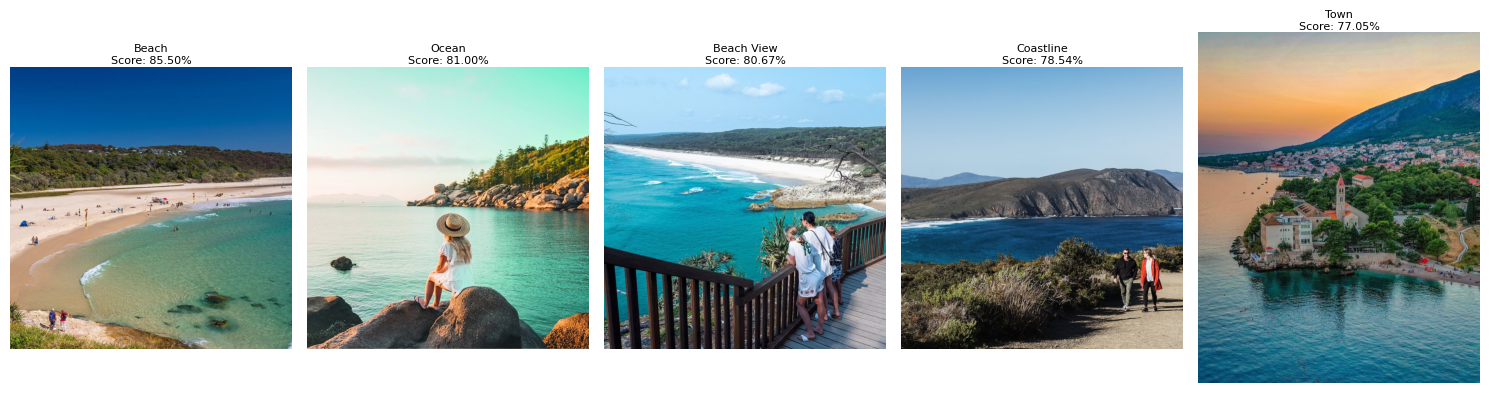

In [24]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import textwrap

# Display images and metadata
rows = 2
columns = 5
fig = plt.figure(figsize=(15, 8))

for index, value in enumerate(text_based_search_response["hits"]["hits"], 1): 
    ax = fig.add_subplot(rows, columns, index)
    image_path = value["_source"]["image_path"]
    image = np.array(Image.open(f'./image_data/{image_path}'))

    # Display the image
    ax.imshow(image)
    ax.axis("off") 

    # Display product description and score below the image
    product_description = value["_source"]["image_title"]
    wrapped_description = "\n".join(textwrap.wrap(product_description, width=20))
    
    score = f'Score: {value["_score"]:.2%}'
    
    # Set title and description below the image
    title = f'{wrapped_description}\n{score}'
    ax.set_title(title, fontsize=8, pad=2)

plt.tight_layout()
plt.show()

## Test with Image-based search
Next, I upload an image as a request for semantic search instead of a text/product description and then retrieve images semantically similar to the requested image. This is what my input image in location './image_data/images/test/1358.jpeg' looks like:

<image>

The code below retrieves the vector embeddings for the input Image by invoking the Amazon Titan Multimodal Embeddings model and then I search the retrieved vector embeddings against the OpenSearch Index. The retrieved documents from OpenSearch are obtained in the variable image_based_search_response

In [25]:
# Test
import os
import json
import base64
import boto3
def get_embedding_for_image(image_path):
    with open(image_path, "rb") as image_file:
            input_image = base64.b64encode(image_file.read()).decode('utf8')
    body = json.dumps( 
        {
            "inputImage": input_image
        }
    )
    response = bedrock.invoke_model( 
        body=body,
        modelId="amazon.titan-embed-image-v1", 
        accept="application/json", 
        contentType="application/json"
    )
    
    vector_json = json.loads(response['body'].read().decode('utf8'))
    return vector_json, input_image 

image_embedding = get_embedding_for_image("./test_data/t003.jpg")

query = {
    "size": 5,
    "query": {
        "knn": {
        "multimodal_vector": {
            "vector": image_embedding[0]['embedding'],
            "k": 5
        }
        }
    },
    "_source": ["image_title", "image_path", "image_labels", "image_class", "image_url"]
}

try:
    image_based_search_response = client.search(body=query, 
    index="image-search-multimodal-index")
    print(json.dumps(image_based_search_response, indent=2))
except Exception as ex: 
    print(ex)

{
  "took": 61,
  "timed_out": false,
  "_shards": {
    "total": 0,
    "successful": 0,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": {
      "value": 10,
      "relation": "eq"
    },
    "max_score": 0.8110397,
    "hits": [
      {
        "_index": "image-search-multimodal-index",
        "_id": "1%3A0%3AjVy85Y8B-JsMtKpYzrSR",
        "_score": 0.8110397,
        "_source": {
          "image_labels": "Kangaroos Island Beach Sea Ocean Beach",
          "image_class": "sealink",
          "image_path": "019.jpg",
          "image_url": "https://d9yx5bzoplulh.cloudfront.net/019.jpg",
          "image_title": "Kangaroo Island"
        }
      },
      {
        "_index": "image-search-multimodal-index",
        "_id": "1%3A0%3Afly85Y8B-JsMtKpYzrSR",
        "_score": 0.726444,
        "_source": {
          "image_labels": "Coast Hills Hiking Ocean",
          "image_class": "sealink",
          "image_path": "004.jpg",
          "image_url": "https://d9yx5bzoplulh

Finally, I visualize the images retrieved using the matplotlib library and iterating over the image_based_search_response variable initialized in the above code block.

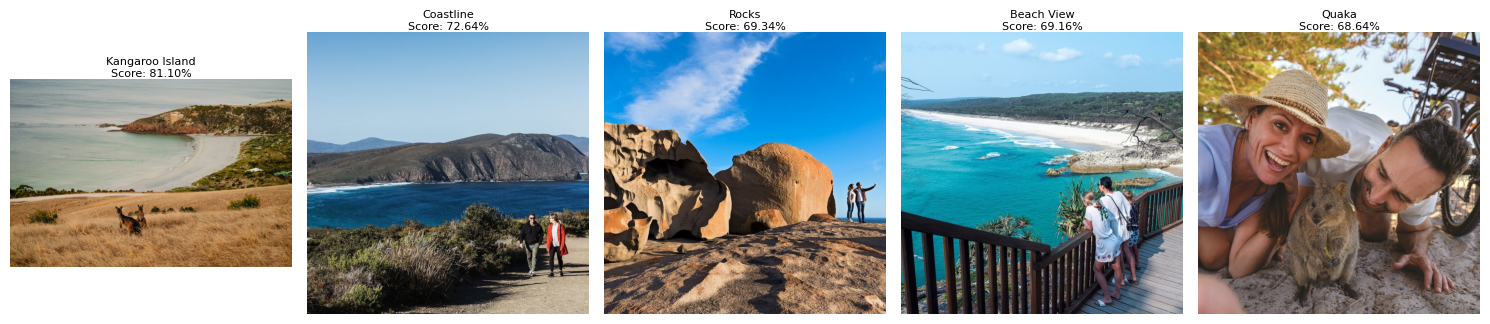

In [26]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import textwrap

# Display images and metadata
rows = 2
columns = 5
fig = plt.figure(figsize=(15, 8))

for index, value in enumerate(image_based_search_response["hits"]["hits"], 1): 
    ax = fig.add_subplot(rows, columns, index)
    image_path = value["_source"]["image_path"]
    image = np.array(Image.open(f'./image_data/{image_path}'))

    # Display the image
    ax.imshow(image)
    ax.axis("off") 

    # Display product description and score below the image
    product_description = value["_source"]["image_title"]
    wrapped_description = "\n".join(textwrap.wrap(product_description, width=20))
    
    score = f'Score: {value["_score"]:.2%}'
    
    # Set title and description below the image
    title = f'{wrapped_description}\n{score}'
    ax.set_title(title, fontsize=8, pad=2)

plt.tight_layout()
plt.show()